In [1]:
import numpy as np
import matplotlib.pyplot as plt #matplob lib
%matplotlib inline
import os

import astropy.io.ascii as at
#from scipy.interpolate import griddata, LinearNDInterpolator, interp2d
import numpyro
import numpyro.distributions as dist
import jax
from jax import random
import jax.numpy as jnp
from jax import jit

In [2]:
# read in our MIST isochrone
iso = at.read("MIST_iso_67e56fd8ac521.iso.cmd")

# filter out AGB/RGB stars so we're left with just main sequence stars
ms = (iso['EEP'] < 605) & (iso['log_g'] > 2.0)
iso = iso[ms]

# sanity print mins and maxs of logg and teff
(min(iso['log_g']), max(iso['log_g']),
10**min(iso['log_Teff']), 10**max(iso['log_Teff']))

(np.float64(2.016473965578847),
 np.float64(5.219173330672141),
 np.float64(2852.90475694454),
 np.float64(6611.359927800581))

In [3]:
# JAXify the important MIST isochrone data
isoTeff = jnp.array(10**iso['log_Teff'])
isologg = jnp.array(iso['log_g'])
isoinitmass = jnp.array(iso['initial_mass'])

@jit
def find_closest_mass(sample_temp, sample_logg):
    # calculate distance to MIST isochrone points in (temp, logg) space
    distances = jnp.sqrt((isoTeff - sample_temp)**2
                         + (isologg - sample_logg)**2)
    
    # find indices of 2 closest points
    idx_closest = jnp.argsort(distances)[:2]
    
    # extract the two closest temps and init masses
    teff1, teff2 = isoTeff[idx_closest[0]], isoTeff[idx_closest[1]]
    # logg1, logg2 = isologg[idx_closest[0]], isologg[idx_closest[1]]
    mass1, mass2 = isoinitmass[idx_closest[0]], isoinitmass[idx_closest[1]]
    
    # interpolate in temp to grab primary mass
    interpolated_mass = jnp.interp(x=sample_temp,
                                   xp=jnp.array([teff1, teff2]),
                                   fp=jnp.array([mass1, mass2])
                                   )
    
    return interpolated_mass

# quick example
# sample_temp = 3000.0  # Replace with your random value
# sample_logg = 3.0     # Replace with your random value
# mass = find_closest_mass(sample_temp, sample_logg)
# print(mass)

In [17]:
##### Create sample using distributions #####

# define priors for Teff_a, log(g), and mass_ratio
teffa_prior = dist.Uniform(min(isoTeff), max(isoTeff))
logga_prior = dist.Uniform(min(isologg), max(isologg))
q_prior = dist.Uniform(low=1E-6, high=1.0)

# sample the priors
sample_i = {}

sample_i['Teff_a'] = teffa_prior.sample(random.PRNGKey(0))
sample_i['log(g)_a'] = logga_prior.sample(random.PRNGKey(0))
sample_i['q'] = q_prior.sample(random.PRNGKey(0))

sample_i

{'Teff_a': Array(6414.6685, dtype=float32),
 'log(g)_a': Array(5.0515666, dtype=float32),
 'q': Array(0.94766706, dtype=float32)}

In [5]:
##### Manually assign priors #####
sample_i = {}

sample_i['Teff_a'] = 3000.0
sample_i['log(g)_a'] = 3.0
sample_i['q'] = 0.8

In [6]:
##### Grab primary mass #####
sample_i['M_a'] = find_closest_mass(sample_i['Teff_a'], sample_i['log(g)_a'])
sample_i['M_a']

Array(0.14551444, dtype=float32)

In [7]:
@jit
def find_closest_teff_logg(mass_a, q):
    # calculate secondary mass
    mass_b = mass_a * q

    # find closest masses on MIST isochrone to mass_b
    distances = jnp.abs(isoinitmass - mass_b)
    
    # find indices of 2 closest points
    idx_closest = jnp.argsort(distances)[:2]
    
    # extract the two closest temps and log(g)s
    teff1, teff2 = isoTeff[idx_closest[0]], isoTeff[idx_closest[1]]
    logg1, logg2 = isologg[idx_closest[0]], isologg[idx_closest[1]]
    mass1, mass2 = isoinitmass[idx_closest[0]], isoinitmass[idx_closest[1]]
    
    # interpolate in temp to grab primary mass
    interpolated_teff = jnp.interp(x=mass_a,
                                   xp=jnp.array([mass1, mass2]),
                                   fp=jnp.array([teff1, teff2])
                                   )
    
    interpolated_logg = jnp.interp(x=mass_a,
                                   xp=jnp.array([mass1, mass2]),
                                   fp=jnp.array([logg1, logg2])
                                   )
    
    return mass_b, interpolated_teff, interpolated_logg

# quick example
mass_a = 1.0
q = 0.8
mass_b, teff, logg = find_closest_teff_logg(mass_a, q)
print(teff, logg)

4827.7217 4.6057315


In [ ]:
##### Grab secondary mass, Teff, log(g) #####
sample_i['M_b'], sample_i['Teff_b'], sample_i['log(g)_b'] = find_closest_teff_logg(mass_a, sample_i['q'])
sample_i['M_b'], sample_i['Teff_b'], sample_i['log(g)_b']

(Array(1.2353858, dtype=float32, weak_type=True),
 Array(6406.6025, dtype=float32),
 Array(4.228769, dtype=float32))

In [9]:
sample_i

{'Teff_a': 3000.0,
 'log(g)_a': 3.0,
 'q': 0.8,
 'M_a': Array(0.14551444, dtype=float32),
 'M_b': Array(1.2353858, dtype=float32, weak_type=True),
 'Teff_b': Array(6406.6025, dtype=float32),
 'log(g)_b': Array(4.228769, dtype=float32)}

In [29]:
sample_i['Teff_a'] = 4500.0
sample_i['log(g)_a'] = 2.5
sample_i['q'] = 0.65
sample_i['M_a'] = find_closest_mass(sample_i['Teff_a'], sample_i['log(g)_a'])

sample_i['M_b'], sample_i['Teff_b'], sample_i['log(g)_b'] = find_closest_teff_logg(sample_i['M_a'], sample_i['q'])

In [50]:
# define priors for Teff_a, log(g), and mass_ratio
teffa_prior = dist.Uniform(min(isoTeff), max(isoTeff))
logga_prior = dist.Uniform(min(isologg), max(isologg))
q_prior = dist.Uniform(low=1E-6, high=1.0)

# sample the priors
sample_i = {}

sample_i['Teff_a'] = teffa_prior.sample(random.PRNGKey(0))
sample_i['log(g)_a'] = logga_prior.sample(random.PRNGKey(0))
sample_i['q'] = q_prior.sample(random.PRNGKey(0))
sample_i['M_a'] = find_closest_mass(sample_i['Teff_a'], sample_i['log(g)_a'])

(sample_i['M_b'], sample_i['Teff_b'], sample_i['log(g)_b']) = find_closest_teff_logg(sample_i['M_a'], sample_i['q'])

{'Teff_a': Array(6414.6685, dtype=float32), 'log(g)_a': Array(5.0515666, dtype=float32), 'q': Array(0.94766706, dtype=float32), 'M_a': Array(1.2630494, dtype=float32), 'M_b': Array(1.1969503, dtype=float32), 'Teff_b': Array(6277.953, dtype=float32), 'log(g)_b': Array(4.3042717, dtype=float32)}
1.2630494

1.1969503


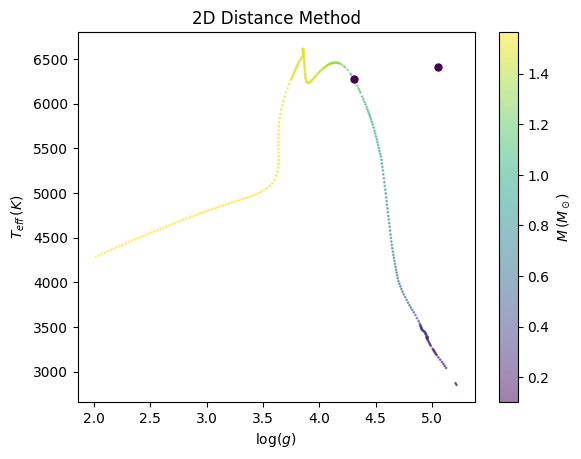

In [28]:
##### Plotting #####
print(sample_i)
print(sample_i['M_a']) 
print()
print(sample_i['M_b'])

fig, ax = plt.subplots()

ax.scatter(isologg, isoTeff, c=isoinitmass, s=1, alpha=0.5)
ax.scatter(sample_i['log(g)_a'], sample_i['Teff_a'], c=sample_i['M_a'], s=25, label='Primary')
ax.scatter(sample_i['log(g)_b'], sample_i['Teff_b'], c=sample_i['M_b'], s=25, label='Secondary')

ax.set_xlabel(r'$\log(g)$')
ax.set_ylabel(r'$T_{eff} \, (K)$')
ax.set_title("2D Distance Method")

fig.colorbar(ax.collections[0], label=r'$M \, ({M_\odot})$')

In [47]:
out = {}

out['iso'] = iso['log_Teff', 'log_g', 'initial_mass']
out['iso']['Teff'] = 10**out['iso']['log_Teff']
del(out['iso']['log_Teff'])

out

{'iso': <Table length=325>
       log_g            initial_mass           Teff       
      float64             float64            float64      
 ------------------ ------------------- ------------------
  5.219173330672141 0.10331965605076723   2852.90475694454
  5.210097400095176 0.10722995675658707  2871.426772679346
  5.125557731436499 0.14551443880232373  3043.250270866061
  5.113599158725646 0.15196215136678998 3065.8589579837094
  5.101390956760364 0.15863977245194313  3088.979471101631
  5.089240988406002  0.1668724021671966  3110.692582312181
  5.073608290086558 0.17982274249296165 3135.6645730593646
  5.058022948354067 0.19279845940840507  3160.754584925618
  5.042676309900792 0.20552708463359626  3185.587810805356
                ...                 ...                ...
 2.2549880907637156  1.5620623761143935  4421.025583634862
  2.228578765081699  1.5623247724036857  4406.202257441944
  2.202190874455601   1.562577687538609  4391.516989111142
 2.1757419086978294    1.5628